In [20]:
# %load PDF_NJL_QC.py
"""
Created on Thu Oct 29 15:47:33 2020

@author: 824i40
"""

# -*- coding: utf-8 -*-
"""
Created on Wed Oct 28 11:54:06 2020

@author: 82440
"""
import projectq
from multiprocessing import Pool
from projectq.ops import X, Y, Z, H, S, T, CX, CZ, Rx, Ry, Rz, Measure, All,TimeEvolution,QubitOperator,StatePreparation, ControlledGate
from projectq.meta import Control
#GreedyScheduler
import projectq.setups.decompositions
import numpy as np
import math

from qiskit.aqua.components.optimizers import COBYLA, CRS, P_BFGS, L_BFGS_B, POWELL, ADAM, DIRECT_L_RAND, ISRES

import scipy
from openfermion.transforms import jordan_wigner
from openfermion.ops import FermionOperator
from scipy.optimize import minimize_scalar,minimize,basinhopping



def to_H_hiq(H_openfermion):
    # transform the data structure in order to use in hiq
    hams=[]
    H_openfermion=jordan_wigner(H_openfermion)
    terms=H_openfermion.terms
    for k,v in terms.items():
        o_list=[a[1]+str(a[0]) for a in k]
        hams.append(np.real(v)*QubitOperator(' '.join(o_list)))
    ham_total=hams[0]  # simplify this code
    for i in range(1,len(hams)):
        ham_total+=hams[i]
    return ham_total

def bins(n,L):
    bins=[str(int(j)) for j in bin(n)[2:]]
    bins=''.join(bins)
    l=L-len(bins)
    zbins=[str(0) for x in range (0,l)]
    zbins=''.join(zbins)
    zbins=''.join([zbins,bins])
    return zbins[::-1]

def counting(state):
    odd=0
    even=0
    positionF=[]
    positionAF=[]
    num=list(state)
    for i in range(0,len(num),2):
        if num[i]=="1":
            positionF.append(int(i/2))
            even=even+1
    for i in range(1,len(num)+1,2):
        if num[i]=="0":
            positionAF.append(int((i-1)/2))
            odd=odd+1
    return even,odd,positionF,positionAF


class NJL_model():
    def __init__(self,L,m,g,a,boundary):
        self.L=L
        self.m=m
        self.g=g
        self.a=a
        self.boundary=boundary
    
    def hxy(self,i):
        return to_H_hiq(FermionOperator(''.join([str(i%self.L),'^ ',str((i+1)%self.L)]),(-1j)/(2*self.a))+FermionOperator(''.join([str((i+1)%self.L),'^ ',str(i%self.L)]),1j/(2*self.a)))
    
    def hmass(self,i):
        return to_H_hiq(FermionOperator(''.join([str(i%self.L),'^ ',str(i%self.L)]),self.m*(-1)**i))
    
    def hint(self,i):
        A = to_H_hiq(FermionOperator(''.join([str((2*i)%self.L),'^ ',str((2*i)%self.L)]),-self.g/self.a))
        B = to_H_hiq(FermionOperator(''.join([str((2*i+1)%self.L),'^ ',str((2*i+1)%self.L)]),-self.g/self.a))
        C = to_H_hiq(FermionOperator(''.join([str((2*i)%self.L),'^ ',str((2*i)%self.L),' ',str((2*i+1)%self.L),'^ ',str((2*i+1)%self.L)]),2*self.g/self.a))
        return A,B,C
    
    def hzzodd(self):
        hzzodd=0*QubitOperator('')
        for i in range(int(self.L/2)):
            hzzodd=hzzodd+self.hint(i)[1]
        for i in range(self.L):
            if i%2==1:
                hzzodd=hzzodd+self.hmass(i)
        return hzzodd
    
    def hzzeven(self):
        hzzeven=0*QubitOperator('')
        for i in range(int(self.L/2)):
            hzzeven=hzzeven+self.hint(i)[0]+self.hint(i)[2]
        for i in range(self.L):
            if i%2==0:
                hzzeven=hzzeven+self.hmass(i)
        return hzzeven
    
    #The open boundary condition sum i to L-1
    def hxyodd(self):
        hxyodd=0*QubitOperator('')
        if self.boundary=='open':
            for i in range(self.L-1):
                if i%2==1:
                    hxyodd=hxyodd+self.hxy(i)
        if self.boundary=='period':
            for i in range(self.L):
                if i%2==1:
                    hxyodd=hxyodd+self.hxy(i)
        return hxyodd
    
    def hxyeven(self):
        hxyeven=0*QubitOperator('')
        for i in range(self.L):
            if i%2==0:
                hxyeven=hxyeven+self.hxy(i)
        return hxyeven
    
    '''
    def ham(self):
        ham=0*QubitOperator('')
        for i in range(self.L):
            ham=ham+self.hxy(i)+self.hmass(i)
        for i in range(int(self.L/2)):
            ham=ham+(self.hint(i)[0]+self.hint(i)[1]+self.hint(i)[2])
        return ham
    '''
    
    def ham(self):
        return self.hzzodd()+self.hzzeven()+self.hxyodd()+self.hxyeven()
    
    def Pz(self):
        Pz=0*QubitOperator('')
        for i in range(self.L):
            Pz=Pz+to_H_hiq(FermionOperator(''.join([str(i%self.L),'^ ',str((i+2)%self.L)]),-1j/4)+FermionOperator(''.join([str((i+2)%self.L),'^ ',str(i%self.L)]),1j/4))
        return Pz
    
    def J0(self):
        J0=0*QubitOperator('')
        for i in range(self.L):
            J0=J0+to_H_hiq(FermionOperator(''.join([str(i%self.L),'^ ',str(i%self.L)]),1))
        return J0


class ansatz():
    def __init__(self,model,layers):
        self.model=model
        self.layers=layers
        
    
    def initial_state(self):
        ini_state=[0 for i in range(2**(self.model.L+1))]
        for i in range(2**(self.model.L)):
            if counting(bins(i,self.model.L))[0]==1 and counting(bins(i,self.model.L))[1]==1 and counting(bins(i,self.model.L))[2]==counting(bins(i,self.model.L))[3]:
                if (sum(counting(bins(i,self.model.L))[2])+1)%2==0:
                    ini_state[i]=1
                else:
                    ini_state[i]=1
            else:
                ini_state[i]=0
        state=np.matrix(ini_state)
        state=state/np.linalg.norm(state)
        return state.tolist()[0]
    
    
    def initial_state1(self):
        ini_state=[0 for i in range(2**(self.model.L))]
        for i in range(2**(self.model.L)):
            if counting(bins(i,self.model.L))[0]==1 and counting(bins(i,self.model.L))[1]==1 and counting(bins(i,self.model.L))[2]==counting(bins(i,self.model.L))[3]:
                ini_state[i]=1
            else:
                ini_state[i]=0
        state=np.matrix(ini_state)
        state=state/np.linalg.norm(state)
        return state.tolist()[0]
    
    
    def circuit1(self,alpha):
        eng = projectq.MainEngine()
        qureg=eng.allocate_qureg(self.model.L)

        for i in range(self.model.L):
            if i%2==1:
                X | qureg[i]

        for i in range(0,self.layers):
            TimeEvolution(alpha[4*i],self.model.hxyeven()) | qureg
            TimeEvolution(alpha[4*i+1],self.model.hzzeven()) | qureg
            TimeEvolution(alpha[4*i+2],self.model.hxyodd()) | qureg
            TimeEvolution(alpha[4*i+3],self.model.hzzodd()) | qureg

        eng.flush()

        f1=eng.backend.get_expectation_value(self.model.ham(),qureg)
        eng.flush()

        All(Measure) | qureg

        return f1
    
    
    def circuit2(self,alpha):
        eng = projectq.MainEngine()
        qureg=eng.allocate_qureg(self.model.L)

        StatePreparation(self.initial_state1()) | qureg

        for i in range(0,self.layers):
            TimeEvolution(alpha[4*i],self.model.hxyeven()) | qureg
            TimeEvolution(alpha[4*i+1],self.model.hzzeven()) | qureg
            TimeEvolution(alpha[4*i+2],self.model.hxyodd()) | qureg
            TimeEvolution(alpha[4*i+3],self.model.hzzodd()) | qureg

        eng.flush()

        f2=eng.backend.get_expectation_value(self.model.ham(),qureg)
        eng.flush()

        All(Measure) | qureg
        return f2
    
    
    def object_function(self,alpha):
        return self.circuit1(alpha)+0.5*self.circuit2(alpha)
    
    
    def VQE(self):
        params = np.random.rand(4*self.layers)
        #params=np.loadtxt("para_N10-ma02g08.txt").tolist()
        #params=np.array(params+[0 for i in range(2*4)])
        optimizer = scipy.optimize.minimize(fun=self.object_function, x0=params, method='BFGS', options={'gtol': 1e-05, 'eps': 1e-08, 'disp': True})
        return optimizer.x.tolist()
    
    
    
class  fragmentation_function(ansatz):
    def __init__(self,model,model_x,layers,parameters_hx,parameters_x):
        ansatz.__init__(self,model,layers)
        self.parameters_hx=parameters_hx
        self.parameters_x=parameters_x
        self.model_x=model_x
        
    
    def NJL_ene(self,XG):
        eng = projectq.MainEngine()
        qureg=eng.allocate_qureg(self.model.L)
        for i in range(len(XG)):
            X | qureg[XG[i]]
        
        for i in range(self.layers):
            TimeEvolution(self.parameters_hx[4*i],self.model.hxyeven()) | qureg
            TimeEvolution(self.parameters_hx[4*i+1],self.model.hzzeven()) | qureg
            TimeEvolution(self.parameters_hx[4*i+2],self.model.hxyodd()) | qureg
            TimeEvolution(self.parameters_hx[4*i+3],self.model.hzzodd()) | qureg
        
        eng.flush()
        ene=eng.backend.get_expectation_value(self.model.ham(),qureg)
        All(Measure) | qureg
        return ene
        
    
    def NJL_FF(self,loca_h,spacetime,index,gate):
        mea_list=[]
        eng = projectq.MainEngine()
        qureg=eng.allocate_qureg(self.model.L+5)
        
        if loca_h==2:
            loca_x_list=[8,9,0,1]
            print(loca_x_list)
        
        else:
            loca_x_list=[i for i in range(self.model.L)]
            loca_h_list=[(i+2*loca_h-2)%10 for i in range(6)]
            for i in range(6):
                loca_x_list.remove(loca_h_list[i])

            loca_x_list=sorted(loca_x_list)
            loca_h_list=sorted(loca_h_list)

            print(loca_x_list)
        

        for i in range(self.model.L):
            if i%2==1 and i!=2*loca_h and i!=2*loca_h+1:
                X | qureg[i]
                
        X | qureg[2*loca_h]

        for i in range(self.layers):
            TimeEvolution(self.parameters_hx[4*i],self.model.hxyeven()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+1],self.model.hzzeven()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+2],self.model.hxyodd()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+3],self.model.hzzodd()) | [qureg[j] for j in range(self.model.L)]

        for i in range(int(len(parameters_x)/4)):
            TimeEvolution(-self.parameters_x[len(parameters_x)-1-4*i],self.model_x.hzzodd()) | [qureg[loca_x_list[j]] for j in range(4)]
            TimeEvolution(-self.parameters_x[len(parameters_x)-1-4*i-1],self.model_x.hxyodd()) | [qureg[loca_x_list[j]] for j in range(4)]
            TimeEvolution(-self.parameters_x[len(parameters_x)-1-4*i-2],self.model_x.hzzeven()) | [qureg[loca_x_list[j]] for j in range(4)]
            TimeEvolution(-self.parameters_x[len(parameters_x)-1-4*i-3],self.model_x.hxyeven()) | [qureg[loca_x_list[j]] for j in range(4)]
        
        eng.flush()
        print(eng.backend.get_probability('0101',[qureg[loca_x_list[i]] for i in range(4)]))
        
        for i in range(4):
            Measure | qureg[loca_x_list[i]]
            eng.flush()
            mea_list.append(int(qureg[loca_x_list[i]]))
            
        if mea_list!=[0,1,0,1]:
            All(Measure) | qureg
            eng.flush()
            return "fail"
        
        else:
            for i in range(4):
                if loca_x_list[i]%2==1:
                    X | qureg[loca_x_list[i]]
                    
                H | qureg[loca_x_list[i]]
                
                with Control(eng,qureg[loca_x_list[i]]):
                    X | qureg[self.model.L+i]
            
            H | qureg[self.model.L+4]
            
            with Control(eng,qureg[self.model.L+4]):
                TimeEvolution(spacetime[0][0],self.model.ham()) | [qureg[j] for j in range(10)]
                for i in range(2*spacetime[0][1]+index[0]):
                    Z | qureg[i]
                gate[0] | qureg[2*spacetime[0][1]+index[0]]
                TimeEvolution(-spacetime[0][0],self.model.ham()) | [qureg[j] for j in range(10)]
            
            X | qureg[self.model.L+4]
            with Control(eng,qureg[self.model.L+4]):
                TimeEvolution(spacetime[1][0],self.model.ham()) | [qureg[j] for j in range(10)]
                for i in range(2*spacetime[1][1]+index[1]):
                    Z | qureg[i]
                gate[1] | qureg[2*spacetime[1][1]+index[1]]
                TimeEvolution(-spacetime[1][0],self.model.ham()) | [qureg[j] for j in range(10)]
            X | qureg[self.model.L+4]
            
            for i in range(self.layers):
                TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i],self.model.hzzodd()) | [qureg[j] for j in range(self.model.L)]
                TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-1],self.model.hxyodd()) | [qureg[j] for j in range(self.model.L)]
                TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-2],self.model.hzzeven()) | [qureg[j] for j in range(self.model.L)]
                TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-3],self.model.hxyeven()) | [qureg[j] for j in range(self.model.L)]
            
            gate[2] | qureg[self.model.L+4]
            eng.flush()
            
            FF=eng.backend.get_probability('01010101010',[qureg[i] for i in range(self.model.L)]+[qureg[14]])-eng.backend.get_probability('01010101011',[qureg[i] for i in range(self.model.L)]+[qureg[14]])
            
            All(Measure) | qureg
            eng.flush()
            '''
            if int(qureg[self.model.L+4])==0:
                FF=[0,eng.backend.get_probability('0101010101',[qureg[i] for i in range(self.model.L)])]
                All(Measure) | qureg
                eng.flush()
                return FF
            
            if int(qureg[self.model.L+4])==1:
                FF=[1,eng.backend.get_probability('0101010101',[qureg[i] for i in range(self.model.L)])]
                All(Measure) | qureg
                eng.flush()
                return FF
            '''
            return FF
            

            
    def test_FF(self,spacetime,index,gate):
        mea_list=[]
        eng = projectq.MainEngine()
        qureg=eng.allocate_qureg(self.model.L+1)

        for i in range(self.model.L):
            if i%2==1:
                X | qureg[i]

        for i in range(self.layers):
            TimeEvolution(self.parameters_hx[4*i],self.model.hxyeven()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+1],self.model.hzzeven()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+2],self.model.hxyodd()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(self.parameters_hx[4*i+3],self.model.hzzodd()) | [qureg[j] for j in range(self.model.L)]

        H | qureg[self.model.L]
            
        with Control(eng,qureg[self.model.L]):
            TimeEvolution(spacetime[1][0],self.model.ham()) | [qureg[j] for j in range(10)]
            for i in range(2*spacetime[1][1]+index[1]):
                Z | qureg[i]
            gate[1] | qureg[2*spacetime[1][1]+index[1]]
            TimeEvolution(-spacetime[1][0],self.model.ham()) | [qureg[j] for j in range(10)]
            
            TimeEvolution(spacetime[0][0],self.model.ham()) | [qureg[j] for j in range(10)]
            for i in range(2*spacetime[0][1]+index[0]):
                Z | qureg[i]
            gate[0] | qureg[2*spacetime[0][1]+index[0]]
            TimeEvolution(-spacetime[0][0],self.model.ham()) | [qureg[j] for j in range(10)]

        for i in range(self.layers):
            TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i],self.model.hzzodd()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-1],self.model.hxyodd()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-2],self.model.hzzeven()) | [qureg[j] for j in range(self.model.L)]
            TimeEvolution(-self.parameters_hx[len(parameters_hx)-1-4*i-3],self.model.hxyeven()) | [qureg[j] for j in range(self.model.L)]

        gate[2] | qureg[self.model.L]
        eng.flush()

        FF=eng.backend.get_probability('01010101010',[qureg[i] for i in range(self.model.L)]+[qureg[10]])-eng.backend.get_probability('01010101011',[qureg[i] for i in range(self.model.L)]+[qureg[10]])
            
        All(Measure) | qureg
        eng.flush()
        return FF

LT=10
LX=4
layers=10
layers_x=8
model=NJL_model(L=LT,m=0.2,g=0.8,a=1,boundary='period')
model_x=NJL_model(L=LX,m=0.2,g=0.8,a=1,boundary='open')
ans=ansatz(model=model,layers=layers)
ans_x=ansatz(model=model_x,layers=layers_x)
#para=ans_x.VQE()
parameters_hx=np.loadtxt("para_N10-ma02g08.txt")
parameters_x=np.loadtxt("para_N4-ma02g08L8_open.txt")
FF=fragmentation_function(model=model,model_x=model_x,layers=layers,parameters_hx=parameters_hx,parameters_x=parameters_x)

In [30]:
Evac=FF.NJL_ene([1,3,5,7,9])
Eqqbar=FF.NJL_ene([1,2,5,7,9])-Evac
print(FF.NJL_ene([1,3,5,6,7,8,9])-Evac+Eqqbar)
print(FF.NJL_ene([1,2,5,6,7,8,9])-Evac)

3.788037802558832
3.819507809908914


In [10]:
for i in range(5):
    print(FF.NJL_FF(loca_h=i,spacetime=[[0,2],[0,2]],index=[1,1],gate=[X,X,H]))

[4, 5, 6, 7]
0.9463531322437575
4.0990893744935724e-05
[6, 7, 8, 9]
0.946353132243758
1.5002253531613231e-05
[8, 9, 0, 1]
0.9463531322437583
8.305645302803207e-05
[0, 1, 2, 3]
0.9463531322437579
1.8523657844314926e-05
[2, 3, 4, 5]
0.9463531322437579
4.099089374493642e-05


In [3]:
#np.savetxt(fname='para_N4-ma02g08L8_open.txt',X=para)

In [3]:
'''
FF_00=np.zeros((5,5),dtype=np.complex128)
FF_01=np.zeros((5,5),dtype=np.complex128)
FF_10=np.zeros((5,5),dtype=np.complex128)
FF_11=np.zeros((5,5),dtype=np.complex128)
'''
'''
def trans_FF(index,gate):
    FF_00_XX=np.zeros((5,5),dtype=np.float64)
    for loca_h in range(5):
        for st in range(5):
            sucess=0
            for i in range(50):
                nowFF=FF.NJL_FF(loca_h=loca_h,spacetime=[[st-2,4-st],[0,2]],index=index,gate=gate)
                if [st-2,4-st]==[0,2] and nowFF[0]==0 and gate[2]==H:
                    FF_00_XX[loca_h,st]=nowFF[1]
                    break
                else:
                    if nowFF[0]==0 and FF_00_XX[loca_h,st]==0:
                        sucess=sucess+1
                        FF_00_XX[loca_h,st]=FF_00_XX[loca_h,st]+nowFF[1]
                    if nowFF[0]==1 and FF_00_XX[loca_h,st]!=0:
                        sucess=sucess+1
                        FF_00_XX[loca_h,st]=FF_00_XX[loca_h,st]-nowFF[1]
                    if sucess==2:
                        break
    return FF_00_XX
'''

def trans_FF(index,gate):
    FF_00_XX=np.zeros((5,5),dtype=np.float64)
    for loca_h in range(5):
        for st in range(5):
            for i in range(5):
                nowFF=FF.NJL_FF(loca_h=loca_h,spacetime=[[st-2,4-st],[0,2]],index=index,gate=gate)
                if nowFF!="fail":
                    FF_00_XX[loca_h,st]=nowFF
    return FF_00_XX

def trans_testFF(index,gate):
    FF_00_XX=np.zeros(5,dtype=np.float64)
    for st in range(5):
        for i in range(5):
            nowFF=FF.test_FF(spacetime=[[st-2,4-st],[0,2]],index=index,gate=gate)
            if nowFF!="fail":
                    FF_00_XX[st]=nowFF
    return FF_00_XX

In [4]:
FF1_00=trans_FF([0,0],[X,X,H])+trans_FF([0,0],[Y,Y,H])+1j*trans_FF([0,0],[Y,X,H])-1j*trans_FF([0,0],[X,Y,H])
FF1_01=trans_FF([0,1],[X,X,H])+trans_FF([0,1],[Y,Y,H])+1j*trans_FF([0,1],[Y,X,H])-1j*trans_FF([0,1],[X,Y,H])
FF1_10=trans_FF([1,0],[X,X,H])+trans_FF([1,0],[Y,Y,H])+1j*trans_FF([1,0],[Y,X,H])-1j*trans_FF([1,0],[X,Y,H])
FF1_11=trans_FF([1,1],[X,X,H])+trans_FF([1,1],[Y,Y,H])+1j*trans_FF([1,1],[Y,X,H])-1j*trans_FF([1,1],[X,Y,H])

FF2_00=-1j*trans_FF([0,0],[X,X,Rx(np.pi/2)])-1j*trans_FF([0,0],[Y,Y,Rx(np.pi/2)])+trans_FF([0,0],[Y,X,Rx(np.pi/2)])-trans_FF([0,0],[X,Y,Rx(np.pi/2)])
FF2_01=-1j*trans_FF([0,1],[X,X,Rx(np.pi/2)])-1j*trans_FF([0,1],[Y,Y,Rx(np.pi/2)])+trans_FF([0,1],[Y,X,Rx(np.pi/2)])-trans_FF([0,1],[X,Y,Rx(np.pi/2)])
FF2_10=-1j*trans_FF([1,0],[X,X,Rx(np.pi/2)])-1j*trans_FF([1,0],[Y,Y,Rx(np.pi/2)])+trans_FF([1,0],[Y,X,Rx(np.pi/2)])-trans_FF([1,0],[X,Y,Rx(np.pi/2)])
FF2_11=-1j*trans_FF([1,1],[X,X,Rx(np.pi/2)])-1j*trans_FF([1,1],[Y,Y,Rx(np.pi/2)])+trans_FF([1,1],[Y,X,Rx(np.pi/2)])-trans_FF([1,1],[X,Y,Rx(np.pi/2)])

[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[4, 5, 6, 7]
0.9463531322437575
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0.946353132243758
[6, 7, 8, 9]
0

In [5]:
FF_00all=sum([FF1_00[i,:] for i in range(5)])+sum([FF2_00[i,:] for i in range(5)])
FF_01all=sum([FF1_01[i,:] for i in range(5)])+sum([FF2_01[i,:] for i in range(5)])
FF_10all=sum([FF1_10[i,:] for i in range(5)])+sum([FF2_10[i,:] for i in range(5)])
FF_11all=sum([FF1_11[i,:] for i in range(5)])+sum([FF2_11[i,:] for i in range(5)])

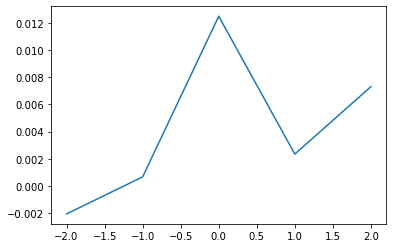

In [8]:
import matplotlib.pyplot as plt
FFall=(FF_00all+FF_01all+FF_10all+FF_11all)*16
ym=np.array([i-2 for i in range(5)])
plt.plot(ym,np.real(FFall))

In [32]:
FF1_00[1,:]

array([ 1.00228653e-05-9.54766367e-06j,  1.61546051e-05-5.62478330e-06j,
        5.14762643e-05+1.69406589e-21j, -5.01831366e-05-8.80604265e-05j,
       -3.29759517e-05-2.18476549e-05j])

count=0
for i in range(1000):
    kkk=FF.NJL_FF(loca_h=1)
    if kkk[0]==[0,1,0,1]:
        count=count+1
    print(kkk,count)

In [6]:
ans.circuit2(parameters_hx)-ans.circuit1(parameters_hx)

2.7131918218171522

In [4]:
testFF1_00=trans_testFF([0,0],[X,X,H])+trans_testFF([0,0],[Y,Y,H])-1j*trans_testFF([0,0],[Y,X,H])+1j*trans_testFF([0,0],[X,Y,H])
testFF1_01=trans_testFF([0,1],[X,X,H])+trans_testFF([0,1],[Y,Y,H])-1j*trans_testFF([0,1],[Y,X,H])+1j*trans_testFF([0,1],[X,Y,H])
testFF1_10=trans_testFF([1,0],[X,X,H])+trans_testFF([1,0],[Y,Y,H])-1j*trans_testFF([1,0],[Y,X,H])+1j*trans_testFF([1,0],[X,Y,H])
testFF1_11=trans_testFF([1,1],[X,X,H])+trans_testFF([1,1],[Y,Y,H])-1j*trans_testFF([1,1],[Y,X,H])+1j*trans_testFF([1,1],[X,Y,H])

testFF2_00=-1j*trans_testFF([0,0],[X,X,Rx(np.pi/2)])-1j*trans_testFF([0,0],[Y,Y,Rx(np.pi/2)])-trans_testFF([0,0],[Y,X,Rx(np.pi/2)])+trans_testFF([0,0],[X,Y,Rx(np.pi/2)])
testFF2_01=-1j*trans_testFF([0,1],[X,X,Rx(np.pi/2)])-1j*trans_testFF([0,1],[Y,Y,Rx(np.pi/2)])-trans_testFF([0,1],[Y,X,Rx(np.pi/2)])+trans_testFF([0,1],[X,Y,Rx(np.pi/2)])
testFF2_10=-1j*trans_testFF([1,0],[X,X,Rx(np.pi/2)])-1j*trans_testFF([1,0],[Y,Y,Rx(np.pi/2)])-trans_testFF([1,0],[Y,X,Rx(np.pi/2)])+trans_testFF([1,0],[X,Y,Rx(np.pi/2)])
testFF2_11=-1j*trans_testFF([1,1],[X,X,Rx(np.pi/2)])-1j*trans_testFF([1,1],[Y,Y,Rx(np.pi/2)])-trans_testFF([1,1],[Y,X,Rx(np.pi/2)])+trans_testFF([1,1],[X,Y,Rx(np.pi/2)])

In [5]:
testall_00=testFF1_00+testFF2_00
testall_01=testFF1_01+testFF2_01
testall_10=testFF1_10+testFF2_10
testall_11=testFF1_11+testFF2_11

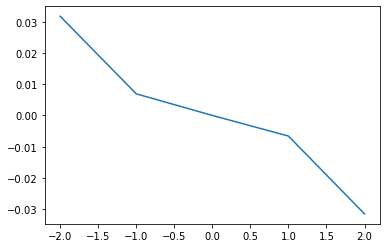

In [9]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(-2,2,5),np.imag(testall_00+testall_01+testall_10+testall_11)/4)

In [8]:
np.imag(testall_00+testall_01+testall_10+testall_11)/4

array([ 3.17344998e-02,  6.90786986e-03,  1.02723385e-13, -6.61014724e-03,
       -3.15158678e-02])

In [31]:
loca_h=4
loca_x_list=[i for i in range(10)]
loca_h_list=[(i+2*loca_h-2)%10 for i in range(6)]
for i in range(6):
    loca_x_list.remove(loca_h_list[i])
    
print(loca_x_list,loca_h_list)   

[2, 3, 4, 5] [6, 7, 8, 9, 0, 1]


In [21]:
FF.NJL_FF(4,[[0,2],[0,2]],[0,0],[X,X,H])

[2, 3, 4, 5] [0, 1, 6, 7, 8, 9]


4.910116868152072e-05

In [22]:
print(loca_h_list)

[8, 9, 0, 1, 2, 3]
